# Predict People with multivariances

In [51]:
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [52]:
import pandas as pd

path = '../data/num_file/hrs_1/p040.csv'
people = pd.read_csv(path, encoding='utf-8')

Merge "date" and "hour" columns to be datetime

In [53]:
people['datetime'] = pd.to_datetime(people['date'])+pd.to_timedelta(people['hour'], unit='h')
people = people.drop(['date', 'hour'], axis=1)
people.set_index('datetime', inplace=True)
people.columns = ['amount']
people['amount'] = people['amount'].astype(float)
print(people)

                      amount
datetime                    
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 12:00:00   1604.0
2022-04-25 15:00:00   4458.0
2022-04-25 16:00:00  18501.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3144 rows x 1 columns]


Resample the data that are not existed

In [54]:
full_index = pd.date_range(start=people.index.min(), end=people.index.max(), freq='h')
people = people.reindex(full_index)
people['amount'] = people['amount'].bfill()
print(people)

                      amount
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 03:00:00   1604.0
2022-04-21 04:00:00   1604.0
2022-04-21 05:00:00   1604.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3251 rows x 1 columns]


Import temperature data.

In [55]:
temperature = pd.read_csv('../data/temperature_file/2022-04.csv')
may = pd.read_csv('../data/temperature_file/2022-05.csv')
temperature = pd.concat([temperature, may])
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
temperature.set_index('datetime', inplace=True)
print(temperature)

                     temperature  precipitation  weather
datetime                                                
2022-04-01 01:00:00          6.0            0.0      NaN
2022-04-01 02:00:00          5.7            0.0      NaN
2022-04-01 03:00:00          5.0            0.0      4.0
2022-04-01 04:00:00          4.8            0.0      NaN
2022-04-01 05:00:00          4.4            0.0      NaN
...                          ...            ...      ...
2022-09-30 20:00:00         20.2            0.0      NaN
2022-09-30 21:00:00         20.3            0.0      1.0
2022-09-30 22:00:00         19.6            0.0      NaN
2022-09-30 23:00:00         18.8            0.0      NaN
2022-10-01 00:00:00         18.8            0.0      NaN

[4392 rows x 3 columns]


Merge the amount of people and temperature data as one dataframe.

In [56]:
data = pd.merge(people, temperature, left_index=True, right_index=True, how='inner')
print(data)

                      amount  temperature  precipitation  weather
2022-04-21 01:00:00   1033.0          9.2            0.0      NaN
2022-04-21 02:00:00     65.0          9.1            0.0      NaN
2022-04-21 03:00:00   1604.0          9.1            0.0      1.0
2022-04-21 04:00:00   1604.0          7.9            0.0      NaN
2022-04-21 05:00:00   1604.0          7.4            0.0      NaN
...                      ...          ...            ...      ...
2022-09-03 07:00:00   9741.0         22.4            0.0      NaN
2022-09-03 08:00:00  19613.0         22.8            0.0      NaN
2022-09-03 09:00:00  22055.0         23.2            0.0      4.0
2022-09-03 10:00:00  14644.0         23.4            0.0      NaN
2022-09-03 11:00:00  12751.0         23.7            0.0      NaN

[3251 rows x 4 columns]


## Data Preprocessing

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()
data[['amount', 'temperature']] = scaler.fit_transform(data[['amount', 'temperature']])

In [59]:
print(data.head())

                       amount  temperature  precipitation  weather
2022-04-21 01:00:00 -1.608170    -2.122485            0.0      NaN
2022-04-21 02:00:00 -1.752224    -2.140183            0.0      NaN
2022-04-21 03:00:00 -1.523196    -2.140183            0.0      1.0
2022-04-21 04:00:00 -1.523196    -2.352552            0.0      NaN
2022-04-21 05:00:00 -1.523196    -2.441039            0.0      NaN


In [60]:
data = data[['amount', 'temperature']]
print(data)

                       amount  temperature
2022-04-21 01:00:00 -1.608170    -2.122485
2022-04-21 02:00:00 -1.752224    -2.140183
2022-04-21 03:00:00 -1.523196    -2.140183
2022-04-21 04:00:00 -1.523196    -2.352552
2022-04-21 05:00:00 -1.523196    -2.441039
...                       ...          ...
2022-09-03 07:00:00 -0.312280     0.213572
2022-09-03 08:00:00  1.156832     0.284362
2022-09-03 09:00:00  1.520241     0.355151
2022-09-03 10:00:00  0.417365     0.390546
2022-09-03 11:00:00  0.135656     0.443638

[3251 rows x 2 columns]


Slice into dataframe

In [61]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [62]:
test = one_step_forecast(data['amount'], 24)

In [63]:
y = test['y']
test = test.drop('y', axis=1)
print(test)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -1.608170 -1.752224 -1.523196 -1.523196 -1.523196   
2022-04-21 02:00:00 -1.752224 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 03:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 04:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
2022-04-21 05:00:00 -1.523196 -1.523196 -1.523196 -1.523196 -1.523196   
...                       ...       ...       ...       ...       ...   
2022-09-02 07:00:00  0.285961  1.057721  0.334623  1.582000  2.100772   
2022-09-02 08:00:00  1.057721  0.334623  1.582000  2.100772  0.787768   
2022-09-02 09:00:00  0.334623  1.582000  2.100772  0.787768  1.724863   
2022-09-02 10:00:00  1.582000  2.100772  0.787768  1.724863  1.419492   
2022-09-02 11:00:00  2.100772  0.787768  1.724863  1.419492  0.644905   

                          x_6       x_7       x_8       x_9      x_10  ...  \
2022-04-21 01:00:00 -1.523196 -1.523196 -1.52

In [64]:
test_2 = one_step_forecast(data['temperature'], 24)

In [65]:
test_2.drop('y', axis=1, inplace=True)
print(test_2)

                          x_1       x_2       x_3       x_4       x_5  \
2022-04-21 01:00:00 -2.122485 -2.140183 -2.140183 -2.352552 -2.441039   
2022-04-21 02:00:00 -2.140183 -2.140183 -2.352552 -2.441039 -2.246367   
2022-04-21 03:00:00 -2.140183 -2.352552 -2.441039 -2.246367 -1.821630   
2022-04-21 04:00:00 -2.352552 -2.441039 -2.246367 -1.821630 -1.308405   
2022-04-21 05:00:00 -2.441039 -2.246367 -1.821630 -1.308405 -0.972154   
...                       ...       ...       ...       ...       ...   
2022-09-02 07:00:00  0.425941  0.585217  0.850678  1.063047  0.903771   
2022-09-02 08:00:00  0.585217  0.850678  1.063047  0.903771  1.063047   
2022-09-02 09:00:00  0.850678  1.063047  0.903771  1.063047  0.956863   
2022-09-02 10:00:00  1.063047  0.903771  1.063047  0.956863  1.027652   
2022-09-02 11:00:00  0.903771  1.063047  0.956863  1.027652  0.939165   

                          x_6       x_7       x_8       x_9      x_10  ...  \
2022-04-21 01:00:00 -2.246367 -1.821630 -1.30

In [66]:
print(y)

2022-04-21 01:00:00   -1.098475
2022-04-21 02:00:00   -1.098475
2022-04-21 03:00:00   -1.098475
2022-04-21 04:00:00   -1.098475
2022-04-21 05:00:00   -1.098475
                         ...   
2022-09-02 07:00:00   -0.312280
2022-09-02 08:00:00    1.156832
2022-09-02 09:00:00    1.520241
2022-09-02 10:00:00    0.417365
2022-09-02 11:00:00    0.135656
Name: y, Length: 3227, dtype: float64


Divide to train and test and val

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
train_people, test_people, train_temperature, test_temperature, train_y, test_y = train_test_split(test, test_2, y, test_size=0.15, shuffle=False)
train_people, val_people, train_temperature, val_temperature, train_y, val_y = train_test_split(train_people, train_temperature, train_y, test_size=0.15, shuffle=False)
index = test_y.index
train_people = np.expand_dims(train_people, axis=-1)
val_people = np.expand_dims(val_people, axis=-1)
test_people = np.expand_dims(test_people, axis=-1)
train_temperature = np.expand_dims(train_temperature, axis=-1)
val_temperature = np.expand_dims(val_temperature, axis=-1)
test_temperature = np.expand_dims(test_temperature, axis=-1)
y_train = np.expand_dims(train_y, axis=-1)
y_val = np.expand_dims(val_y, axis=-1)
y_test = np.expand_dims(test_y, axis=-1)

## Create model

In [69]:
from keras.models import Model
from keras import layers
from keras import Input
from keras.metrics import RootMeanSquaredError as RMSE, MeanAbsoluteError as MAE
from keras import callbacks

In [70]:
people_input = Input(shape=(train_people.shape[1], train_people.shape[2]), name='people')
temperature_input = Input(shape=(train_temperature.shape[1], train_temperature.shape[2]), name='temperature')

In [71]:
print(people_input.shape)

(None, 24, 1)


In [72]:
units = 32
people_lstm = layers.LSTM(units, name='people_lstm')(people_input)
temperature_lstm = layers.LSTM(units, name='temperature_lstm')(temperature_input)

In [73]:
concat= layers.concatenate([people_lstm, temperature_lstm], name='concat')
output = layers.Dense(1, name='output')(concat)

In [74]:
model = Model([people_input, temperature_input], output)

In [75]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 people (InputLayer)            [(None, 24, 1)]      0           []                               
                                                                                                  
 temperature (InputLayer)       [(None, 24, 1)]      0           []                               
                                                                                                  
 people_lstm (LSTM)             (None, 32)           4352        ['people[0][0]']                 
                                                                                                  
 temperature_lstm (LSTM)        (None, 32)           4352        ['temperature[0][0]']            
                                                                                            

In [76]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RMSE(), MAE()])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit([train_people, train_temperature], y_train, epochs=200, batch_size=32, shuffle=False, validation_data=([val_people, val_temperature], y_val), callbacks=[es])

Epoch 1/200
73/73 [==============================] - 6s 27ms/step - loss: 0.7833 - root_mean_squared_error: 0.8850 - mean_absolute_error: 0.7483 - val_loss: 0.2436 - val_root_mean_squared_error: 0.4935 - val_mean_absolute_error: 0.3724
Epoch 2/200
73/73 [==============================] - 1s 15ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851 - mean_absolute_error: 0.3592 - val_loss: 0.0975 - val_root_mean_squared_error: 0.3122 - val_mean_absolute_error: 0.2418
Epoch 3/200
73/73 [==============================] - 1s 14ms/step - loss: 0.1392 - root_mean_squared_error: 0.3731 - mean_absolute_error: 0.2764 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2888 - val_mean_absolute_error: 0.2234
Epoch 4/200
73/73 [==============================] - 1s 15ms/step - loss: 0.1103 - root_mean_squared_error: 0.3321 - mean_absolute_error: 0.2478 - val_loss: 0.0766 - val_root_mean_squared_error: 0.2768 - val_mean_absolute_error: 0.2134
Epoch 5/200
73/73 [==============================] - 1s 

In [77]:
eval_result = model.evaluate([test_people, test_temperature], y_test)
print(eval_result)

16/16 [==============================] - 0s 7ms/step - loss: 0.0740 - root_mean_squared_error: 0.2720 - mean_absolute_error: 0.1955
[0.07400637865066528, 0.2720411419868469, 0.1954783797264099]


<Axes: >

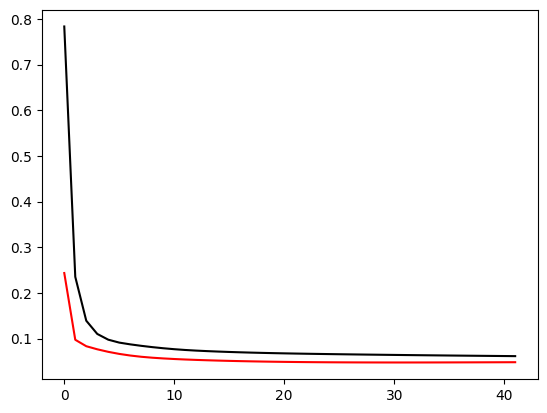

In [78]:
pd.Series(history.history['loss']).plot(style='k')
pd.Series(history.history['val_loss']).plot(style='r')

In [79]:
result = model.predict([test_people, test_temperature])[-1]

16/16 [==============================] - 1s 6ms/step


In [80]:
print(result)

[0.8217608]


In [81]:
result = [result[-1], result[-1]]

In [82]:
result = np.array(result)

In [83]:
result = scaler.inverse_transform(result.reshape(1, -1))

In [84]:
print(result[0][0])

17361.42


In [85]:
res = np.array([test_y.iloc[-1], test_y.iloc[-1]])
res = scaler.inverse_transform(res.reshape(1, -1))
print(res[0][0])

12751.0


In [86]:
result = model.predict([test_people, test_temperature])

16/16 [==============================] - 0s 7ms/step


In [87]:
def plot_forecast(test_y, result, index=index):
    plt.plot(index, test_y, label='actual')
    plt.plot(index, result, label='forecast')
    plt.legend()
    plt.show()

In [88]:
test_y_ex = np.array([test_y, test_y])

In [89]:
test_y_ex = np.array(test_y_ex.T)

In [90]:
print(test_y_ex.shape)

(485, 2)


In [91]:
test_y = scaler.inverse_transform(test_y_ex)

In [92]:
print(test_y[:, 0])

[ 3910.  4031.  5807.  7202.  9444. 12798. 13134. 14116. 12800. 11388.
 12411. 12229.  7530.  5348.  6680.  6431.  4717.  4047.  4305.  3997.
  3988.  2295.  2416.  3753.  4170.  5492.  6024.  9016. 11629. 14193.
 10913.  8191.  8577.  8610. 10059.  8373.  7772.  6518.  5768.  4958.
  4763.  4491.  4530.  4496.  4118.  2921.  3301.  3335.  4942.  9130.
 10375. 11173. 14430. 16136. 16037. 17111. 16096. 14379. 14793. 14239.
 11939.  9600.  7850.  6463.  5443.  5165.  4924.  4764.  4872.  3292.
  3673.  3958.  5875.  9780. 11876. 12144. 13215. 14322. 18572. 19070.
 18182. 17352. 17554. 16795. 13224. 10401.  7993.  6648.  5902.  5706.
  5297.  5378.  5059.  4250.  4915.  5103.  6708. 12076. 15013. 15057.
 17617. 20683. 23015. 22104. 23203. 23976. 24702. 21751. 22529. 15821.
  9768.  7091.  6484.  7109.  7739.  7487.  7342.  6571.  7518.  7702.
  9944. 13593. 16188. 20538. 22418. 26811. 27704. 23078. 22956. 23848.
 21624. 18722. 16849. 14199. 10909.  8326.  7096.  6627.  6548.  6438.
  6044

In [93]:
result = np.array([result[:, 0], result[:, 0]])

In [94]:
result = result.T
print(result.shape)

(485, 2)


In [95]:
result = scaler.inverse_transform(result)

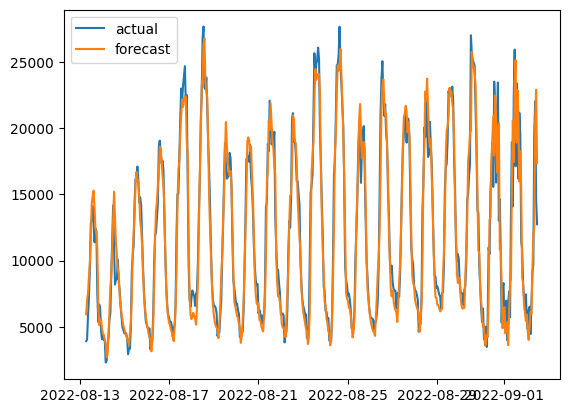

In [96]:
plot_forecast(test_y[:, 0], result[:, 0])

In [97]:
def plot_error(test_y, result):
    error = test_y - result
    plt.plot(index, error, label='error')
    plt.title(f'Error MAE: {np.mean(np.abs(error)):.2f} RMSE: {np.sqrt(np.mean(error**2)):.2f}')
    plt.legend()
    plt.show()

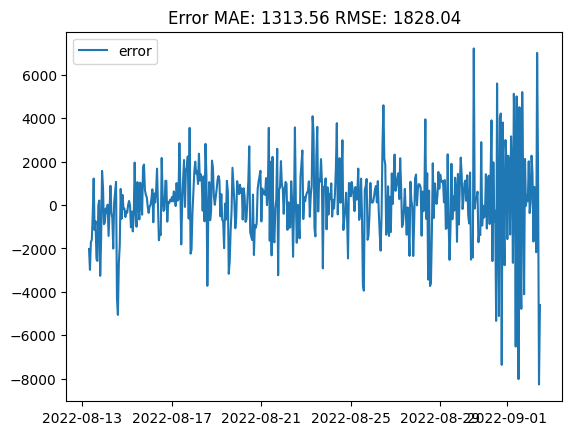

In [98]:
plot_error(test_y[:, 0], result[:, 0])